In [77]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import os
import glob
import json
import geopandas as gp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from scipy import stats



In [7]:
data_path = '../../data/'

In [8]:
NIS_name = pd.read_csv(data_path+'raw/GIS/NIS_name.csv')
NIS_arrondissement = pd.read_csv(data_path+'raw/GIS/NIS_arrondissement.csv')
inhabitants = pd.read_csv(data_path+'raw/GIS/inhabitants.csv')
inhabitants.NIS = inhabitants.NIS.astype(str)

In [3]:
samples_path = '../../data/interim/model_parameters/arrondissements/'

In [4]:
sample_dicts = {}
for filename in glob.glob(os.path.join(samples_path+'*.json')):
    arr = filename.split('/')[-1].split('_2020')[0]
    with open(filename, 'r') as fp:
        sample_dicts[arr] = json.load(fp)

In [30]:
R0_dict = {arr:np.mean(sample_dicts[arr]['R0']).round(2) for arr in sample_dicts.keys()}
R0_df = pd.DataFrame.from_dict(R0_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'R0'})
beta_dict = {arr:np.mean(sample_dicts[arr]['beta']).round(2) for arr in sample_dicts.keys()}
beta_df = pd.DataFrame.from_dict(beta_dict, orient='index').reset_index().rename(columns={'index':'NIS',0:'beta'})


In [ ]:
## Create arrondissements shapefile
# gemeentes = gp.read_file("../../data/raw/geopandas/BE/AD_2_Municipality.shp")
# gemeentes['short_nis'] = gemeentes.NISCode.apply(lambda x: str(x)[:2])
# # select the columns that you with to use for the dissolve and that will be retained
# gemeentes_new = gemeentes[['short_nis','geometry']]
# # dissolve the state boundary by region 
# arrondissementen = gemeentes_new.dissolve(by='short_nis').reset_index()
# arrondissementen['NIS'] = arrondissementen.short_nis.apply(lambda x: x+'000')
# arrondissementen = arrondissementen[['NIS','geometry']]
# arrondissementen.to_file('../../data/raw/geopandas/BE/Arrondissements.shp')

In [13]:
# Read arrondissements shapefile
arrondissementen = gp.read_file(data_path+"raw/GIS/shapefiles/BE/Arrondissements.shp")
provinces = gp.read_file(data_path+"raw/GIS/shapefiles/BE/AD_4_Province.shp")

In [16]:
arrondissementen['area'] = arrondissementen.geometry.area

In [58]:
arrondissementen_ext = pd.merge(arrondissementen, inhabitants[['NIS', 'inhabitants']], on='NIS')
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, R0_df, on='NIS'))
arrondissementen_ext = gp.GeoDataFrame(pd.merge(arrondissementen_ext, beta_df, on='NIS'))
arrondissementen_ext['density_per_km2'] = arrondissementen_ext.inhabitants/arrondissementen_ext.area*1e6

In [67]:
arrondissementen_ext[arrondissementen_ext.density_per_km2>6000]

,NIS,geometry,area,inhabitants,R0,beta,density_per_km2
3,21000,"POLYGON Z ((649703.265 662499.761 0.000, 64960...",1.624199e+08,1218255.0,2.11,0.03,7500.653379


Text(0.5, 1.0, 'R0 vs density: R$^2$ = 0.02, p = 0.39')

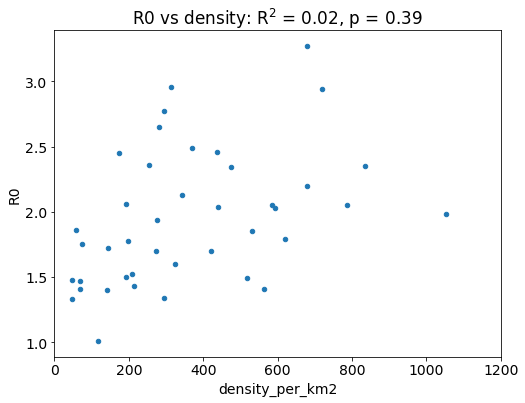

In [85]:
fig, ax = plt.subplots(figsize=(8,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(arrondissementen_ext.density_per_km2,arrondissementen_ext.R0)
pd.DataFrame(arrondissementen_ext).plot(x='density_per_km2', y='R0', kind='scatter', ax=ax)
ax.set_xlim(0,1200)
ax.set_title('R0 vs density: R$^2$ = {:.2f}, p = {:.2f}'.format(r_value**2, p_value))

In [82]:
r_value**2

0.018628574325954172

Text(0.5, 1, 'R0 per arrondissement')

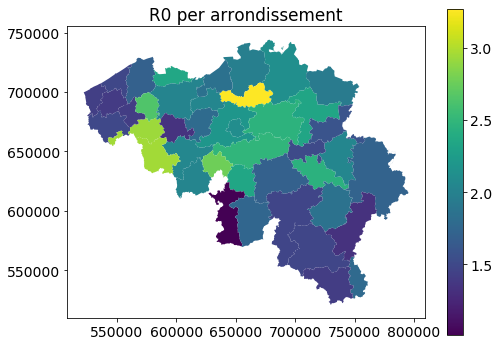

In [76]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='R0', cmap='viridis', ax=ax, legend=True)
ax.set_title('R0 per arrondissement')

Text(0.5, 1, 'beta per arrondissement')

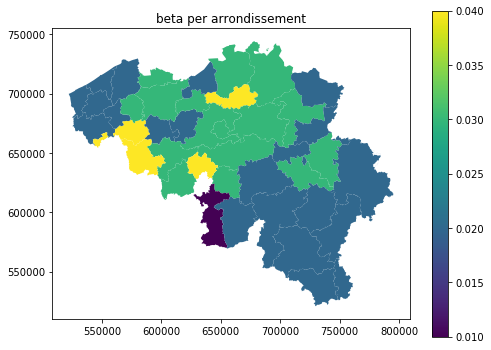

In [39]:
fig,ax = plt.subplots(figsize=(8,6))
arrondissementen_ext.plot(column='beta', cmap='viridis', ax=ax, legend=True)
ax.set_title('beta per arrondissement')

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
provinces.plot(ax=ax)